# 线性回归

## 矢量计算
在模型训练或预测时，我们常常会同时处理多个数据样本并用到矢量计算。在介绍线性回归的矢量计算表达式之前，让我们先考虑对两个向量相加的两种方法。


1. 向量相加的一种方法是，将这两个向量按元素逐一做标量加法。
2. 向量相加的另一种方法是，将这两个向量直接做矢量加法。

In [2]:
import torch
import time

In [3]:
n = 1000
a = torch.ones(n)
b = torch.ones(n)

In [7]:
class Timer(object):
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        # start the timer
        self.start_time = time.time()

    def stop(self):
        # stop the timer and record time into a list
        self.times.append(time.time() - self.start_time)
        return self.times[-1]

    def avg(self):
        # calculate the average and return
        return sum(self.times)/len(self.times)

    def sum(self):
        # return the sum of recorded time
        return sum(self.times)

将两个向量使用for循环按元素逐一做标量加法:

In [6]:
timer = Timer()
c = torch.zeros(n)
for i in range(n):
    c[i] = a[i] + b[i]
'%.5f sec' % timer.stop()

'0.01695 sec'

使用torch来将两个向量直接做矢量加法：

In [8]:
timer.start()
d = a + b
'%.5f sec' % timer.stop()

'0.00103 sec'

## 线性回归模型从零开始的实现

In [10]:
# import packages and modules
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__)

1.3.0


### 生成数据集
使用线性模型来生成数据集，生成一个1000个样本的数据集，下面是用来生成数据的线性关系：

$$
\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b
$$



In [13]:
num_inputs = 2
num_examples = 1000

true_w = [2,-3.4]
true_b = 4.2

In [19]:
features = torch.randn(num_examples,num_inputs,dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

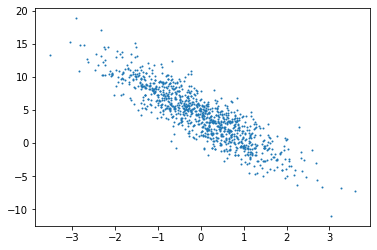

In [21]:
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

### 读取数据集

In [22]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # random read 10 samples
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # the last time may be not enough for a whole batch
        yield  features.index_select(0, j), labels.index_select(0, j)

In [23]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.1121,  0.3033],
        [ 1.5816, -0.6762],
        [-0.8737,  0.2556],
        [ 1.5442, -0.5636],
        [ 1.5050,  0.7135],
        [-0.2076,  1.1663],
        [ 0.0711, -1.9750],
        [-0.9178, -1.3534],
        [ 1.1650,  0.6457],
        [ 1.6773,  0.9887]]) 
 tensor([ 3.3824,  9.6688,  1.5699,  9.2052,  4.7699, -0.1831, 11.0601,  6.9727,
         4.3283,  4.1957])


### 初始化模型参数

In [24]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

### 定义模型
定义用来训练参数的训练模型：

$$
\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b
$$



In [26]:
def linreg(X, w, b):
    return torch.mm(X, w) + b

### 定义损失函数
我们使用的是均方误差损失函数：
$$
l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2,
$$


In [27]:
def squared_loss(y_hat, y): 
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

### 定义优化函数
优化函数使用的是小批量随机梯度下降：

$$
(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b)
$$

In [28]:
def sgd(params, lr, batch_size): 
    for param in params:
        param.data -= lr * param.grad / batch_size # ues .data to operate param without gradient track

### 训练

In [29]:
lr = 0.03
num_epochs = 5

net = linreg
loss = squared_loss

for epoch in range(num_epochs):

    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  
        l.backward()  
        sgd([w, b], lr, batch_size)  
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.024799
epoch 2, loss 0.000084
epoch 3, loss 0.000046
epoch 4, loss 0.000046
epoch 5, loss 0.000046


In [30]:
w, true_w, b, true_b

(tensor([[ 2.0004],
         [-3.3998]], requires_grad=True),
 [2, -3.4],
 tensor([4.1996], requires_grad=True),
 4.2)

## 使用pytorch的简洁实现

In [31]:
import torch
from torch import nn
import numpy as np
torch.manual_seed(1)

print(torch.__version__)
torch.set_default_tensor_type('torch.FloatTensor')

1.3.0


### 生成数据集

In [32]:
num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

### 读取数据集

In [43]:
import torch.utils.data as Data

batch_size = 10

dataset = Data.TensorDataset(features, labels)

data_iter = Data.DataLoader(
    dataset=dataset,            
    batch_size=batch_size,      
    shuffle=True,               
    num_workers=2,           
)

In [34]:
for X, y in data_iter:
    print(X, '\n', y)
    break

tensor([[-1.2091,  1.1710],
        [-0.5768, -1.1467],
        [-0.0043, -0.5005],
        [-2.1674,  1.2210],
        [ 1.5445, -0.3978],
        [ 1.2460,  0.5179],
        [-0.4373, -1.4310],
        [-0.7590, -2.1513],
        [-0.1554,  1.3680],
        [ 0.1835,  1.8906]]) 
 tensor([-2.2063,  6.9415,  5.8919, -4.3053,  8.6452,  4.9207,  8.1895, 10.0074,
        -0.7566, -1.8500])


### 定义模型

In [35]:
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()      
        self.linear = nn.Linear(n_feature, 1)

    def forward(self, x):
        y = self.linear(x)
        return y
    
net = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [36]:
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    )

net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))

from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_inputs, 1))
        ]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


### 初始化模型参数

In [37]:
from torch.nn import init

init.normal_(net[0].weight, mean=0.0, std=0.01)
init.constant_(net[0].bias, val=0.0)  # or you can use `net[0].bias.data.fill_(0)` to modify it directly

Parameter containing:
tensor([0.], requires_grad=True)

In [38]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.0142, -0.0161]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


### 定义损失函数

In [39]:
loss = nn.MSELoss()

In [40]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


### 训练

In [41]:
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000253
epoch 2, loss: 0.000123
epoch 3, loss: 0.000154


In [42]:
dense = net[0]
print(true_w, dense.weight.data)
print(true_b, dense.bias.data)

[2, -3.4] tensor([[ 2.0000, -3.4003]])
4.2 tensor([4.1998])


In [2]:
import sys

In [3]:
sys.path

['H:\\learning and training\\伯禹AI\\Dive-into-Deep-Learning\\src\\code\\linear_regression',
 'D:\\program software\\Anaconda3\\python37.zip',
 'D:\\program software\\Anaconda3\\DLLs',
 'D:\\program software\\Anaconda3\\lib',
 'D:\\program software\\Anaconda3',
 '',
 'C:\\Users\\liang\\AppData\\Roaming\\Python\\Python37\\site-packages',
 'D:\\program software\\Anaconda3\\lib\\site-packages',
 'D:\\program software\\Anaconda3\\lib\\site-packages\\win32',
 'D:\\program software\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'D:\\program software\\Anaconda3\\lib\\site-packages\\Pythonwin',
 'D:\\program software\\Anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\liang\\.ipython']

In [4]:
import sys

In [7]:
import sys
sys.path.append("")

SyntaxError: invalid syntax (<ipython-input-8-dfe386d08fe8>, line 1)